# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_settings import ms

def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_29 100027150881 bloomberg barrier options
1     2024_10_29 100220915287 bloomberg asian options


In [2]:
from convsklearn import asian_trainer, barrier_trainer
model = models[0]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
    
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

0     2024_10_29 100027150881 bloomberg barrier options insample.csv
1     2024_10_29 100027150881 bloomberg barrier options outsample.csv
2     2024_10_29 100027150881 bloomberg barrier options.pkl
3     2024_10_29 100027150881 bloomberg barrier options.txt


In [3]:
train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('insample')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('outsample')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
model_fit

spot price 
0        676.03
1        682.43
2        683.09
3        696.44
4        701.13
         ...   
1076    1461.17
1077    1461.21
1078    1461.31
1079    1461.36
1080    1465.27
Name: spot_price, Length: 1081, dtype: float64

strike price 
0        608.42700
1        614.18700
2        614.78100
3        625.32775
4        626.79600
           ...    
9715    1607.28700
9716    1607.33100
9717    1607.44100
9718    1607.49600
9719    1611.79700
Name: strike_price, Length: 9720, dtype: float64

days to maturity 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0      0.017912
1      0.017942
2      0.017970
3      0.017981
4      0.017985
         ...   
992    0.035255
993    0.035276
994    0.035596
995    0.035690
996    0.037735
Name: dividend_rate, Length: 997, dtype: float64

kappa 
0        0.083258
1        0.090921
2        0.098043
3        0.0984

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'barrier']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['barrier_type_name',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(13,
                                                                                       13),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

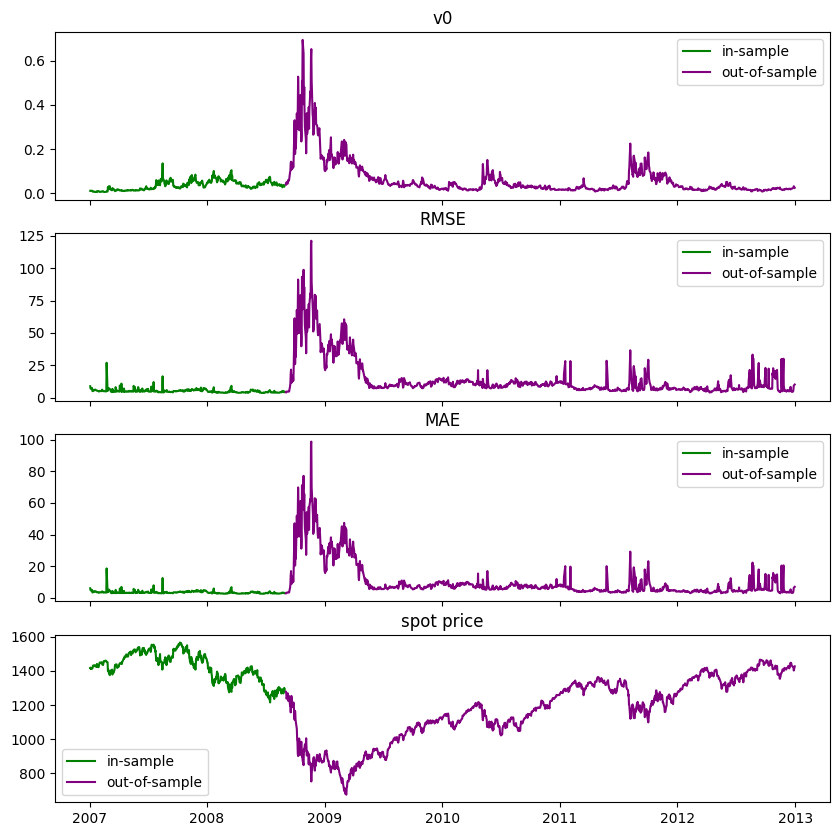

In [4]:
test_diff = test_data['outofsample_error']
train_diff = train_data['insample_error']


test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
test_plot = test_data[reg_cols].copy().drop_duplicates()

train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
train_plot = train_data[reg_cols].copy().drop_duplicates()

fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
for i,col in enumerate(plotcols):
    axs[i].plot(train_plot[col],color='green',label='in-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
for i,col in enumerate(plotcols):
    axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
plt.show()

# Testing

In [5]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
regression_data = test_plot

### testing for the effect of the spot level on pricing accuracy

In [6]:
reg_cols = ['kappa','theta','rho','eta','v0','spot_price','RMSE','MAE']
plotcols = ['v0','RMSE', 'MAE','spot_price']
regression_data.dtypes

kappa         float64
theta         float64
rho           float64
eta           float64
v0            float64
spot_price    float64
RMSE          float64
MAE           float64
dtype: object

### unrestricted regression

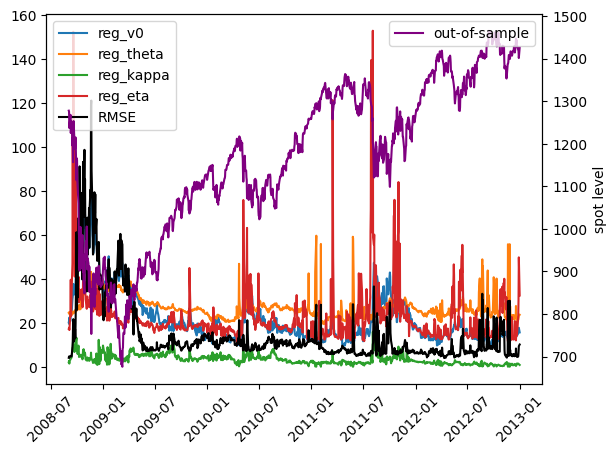

In [8]:
X = pd.DataFrame()
X['reg_s'] = regression_data['spot_price']
X['reg_v0'] = np.sqrt(regression_data['v0'])*100 
X['reg_theta'] = np.sqrt(regression_data['theta'])*100 
X['reg_kappa'] = regression_data['kappa']
X['reg_eta'] = regression_data['eta']*100

target_name = 'RMSE'
y = regression_data[target_name].loc[X.index]
fit_intercept = False

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
ax2 = ax1.twinx()
for column in X.columns[1:]:
    ax1.plot(X.index, X[column], label=column)
ax1.plot(X.index, y, label=target_name, color="black")
ax2.plot(X.index, X['reg_s'], label='out-of-sample', color="purple")
ax2.set_ylabel("spot level")
ax1.legend(loc='upper left')
ax2.legend(loc="upper right")
plt.show()

In [9]:
Ufit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Uyhat = Ufit.predict(X)
URSS = sum((Uyhat-y)**2)
for i,c in enumerate(Ufit.coef_):
    print(f"{X.columns[i].replace('reg_','')} - b{i}:  {c}")
print(f"intercept: {Ufit.intercept_}")
print(f"R Squared: {Ufit.score(X,y)}")
print(f"\nURSS: {URSS}")

s - b0:  -0.009749450428173736
v0 - b1:  1.0194076708926678
theta - b2:  0.3672334710722889
kappa - b3:  -1.4039286204314918
eta - b4:  -0.07661368451908201
intercept: 0.0
R Squared: 0.7911969350757185

URSS: 53032.93701887629


### restricted regression

In [10]:
X = X.iloc[:,1:].copy()
Rfit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Ryhat = Rfit.predict(X)
RRSS = sum((Ryhat-y)**2)
for i,c in enumerate(Rfit.coef_):
    print(f"{X.columns[i].replace('reg_','')} - b{i}:  {c}")
print(f"intercept: {Rfit.intercept_}")
print(f"R Squared: {Rfit.score(X,y)}")
print(f"\nRRSS: {RRSS}")

v0 - b0:  1.2162623555063523
theta - b1:  -0.12025250784854113
kappa - b2:  -1.2269551226410844
eta - b3:  -0.19359607774265492
intercept: 0.0
R Squared: 0.7592484491437095

RRSS: 61147.3870768537


### F-Test

In [11]:
m = len(Ufit.coef_)-len(Rfit.coef_)
n = len(y)
k = len(Ufit.coef_)
dfn = m
dfd = n-k-1
F = ((RRSS-URSS)/dfn)/(URSS/dfd)
alpha = 0.05
critF = stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
print(f"F: {F}, Critical F: {critF}")

F: 166.01340238372566, Critical F: 3.850043646752174


In [12]:
for col in X.columns:
    regression_data[col] = X[col]
regression_data['y'] = y
regression_data['Uyhat'] = Uyhat
regression_data['Ryhat'] = Ryhat
regression_data

,kappa,theta,rho,eta,v0,spot_price,RMSE,MAE,reg_v0,reg_theta,reg_kappa,reg_eta,y,Uyhat,Ryhat
calculation_date,,,,,,,,,,,,,,,
2008-09-02,2.129509,0.060409,-1.000000,0.172868,0.040641,1277.53,4.173915,2.878899,20.159720,24.578213,2.129509,17.286782,4.173915,12.807618,15.604452
2008-09-03,2.693908,0.058609,-1.000000,0.178095,0.038360,1275.25,4.775320,3.253463,19.585714,24.209285,2.693908,17.809461,4.775320,11.276798,14.156994
2008-09-04,1.521139,0.062183,-1.000000,0.167885,0.050277,1236.81,4.359355,3.145253,22.422504,24.936516,1.521139,16.788463,4.359355,16.535181,19.156419
2008-09-05,2.859490,0.059311,-1.000000,0.183520,0.044849,1242.38,4.575543,3.217309,21.177557,24.353805,2.859490,18.351988,4.575543,12.999041,15.767520
2008-09-08,3.372719,0.055250,-0.735338,0.256952,0.043867,1267.76,4.847501,3.440925,20.944396,23.505214,3.372719,25.695196,4.847501,10.919156,13.534655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,1.533653,0.045075,-0.758727,0.187296,0.021678,1425.78,4.544801,3.131509,14.723486,21.230839,1.533653,18.729596,4.544801,5.317255,9.846860
2012-12-26,1.502570,0.045965,-0.631430,0.230292,0.024230,1419.95,4.870463,3.371111,15.566046,21.439524,1.502570,23.029183,4.870463,6.023874,10.052294
2012-12-27,1.254997,0.049897,-0.471477,0.306944,0.026584,1417.38,6.647420,4.572057,16.304571,22.337609,1.254997,30.694357,6.647420,6.891913,9.662351


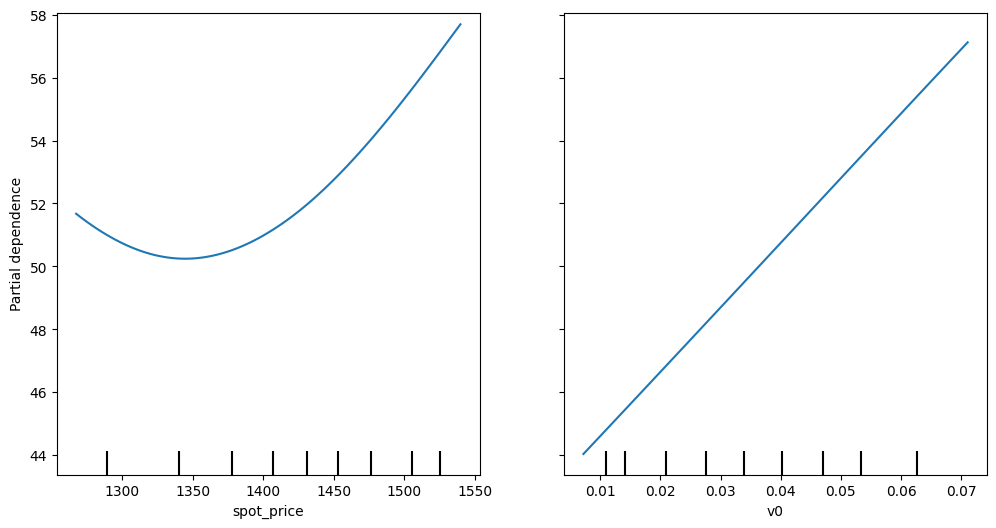

In [13]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
part_disp_X = train_data[model_fit.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, ["spot_price", "v0"], ax=ax)

In [ ]:
new_train = pd.concat([train_data,test_data[test_data.index<=pd.Timestamp(2009,4,1)]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False).copy()
new_test = test_data[~test_data.index.isin(new_train['calculation_date'])].copy().reset_index()
arrs = trainer.get_train_test_arrays(new_train, new_test)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
preprocessor = trainer.preprocess()
retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
insample, outsample, errors = trainer.test_prediction_accuracy(retrained_model,new_test,new_train)
outsample = outsample.set_index('calculation_date')
insample = insample.set_index('calculation_date')


training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001


In [ ]:
test_diff = outsample['outofsample_error']
train_diff = insample['insample_error']

outsample['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
outsample['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
test_plot = outsample[plotcols].copy().drop_duplicates()

insample['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
insample['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
train_plot = insample[plotcols].copy().drop_duplicates()

fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
for i,col in enumerate(plotcols):
    axs[i].plot(train_plot[col],color='green',label='in-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
for i,col in enumerate(plotcols):
    axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
plt.show()